In [4]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.applications import DenseNet169
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
import pandas as pd
import matplotlib.pyplot as plt

In [5]:
# Install the Kaggle package if not already installed
!pip install kaggle

# Download the dataset
!kaggle datasets download -d jutrera/stanford-car-dataset-by-classes-folder

# Unzip the dataset
!unzip stanford-car-dataset-by-classes-folder.zip -d car_data

Streaming output truncated to the last 5000 lines.
  inflating: car_data/car_data/car_data/train/Chrysler Aspen SUV 2009/04381.jpg  
  inflating: car_data/car_data/car_data/train/Chrysler Aspen SUV 2009/04688.jpg  
  inflating: car_data/car_data/car_data/train/Chrysler Aspen SUV 2009/04772.jpg  
  inflating: car_data/car_data/car_data/train/Chrysler Aspen SUV 2009/05544.jpg  
  inflating: car_data/car_data/car_data/train/Chrysler Aspen SUV 2009/05728.jpg  
  inflating: car_data/car_data/car_data/train/Chrysler Aspen SUV 2009/05860.jpg  
  inflating: car_data/car_data/car_data/train/Chrysler Aspen SUV 2009/06146.jpg  
  inflating: car_data/car_data/car_data/train/Chrysler Aspen SUV 2009/06157.jpg  
  inflating: car_data/car_data/car_data/train/Chrysler Aspen SUV 2009/06332.jpg  
  inflating: car_data/car_data/car_data/train/Chrysler Aspen SUV 2009/06441.jpg  
  inflating: car_data/car_data/car_data/train/Chrysler Aspen SUV 2009/06447.jpg  
  inflating: car_data/car_data/car_data/train/C

In [7]:
np.random.seed(42)
tf.random.set_seed(42)

In [8]:
height= 224
width= 224
batch_size= 32

In [9]:
# Define the paths
train_dir = '/content/car_data/car_data/car_data/train'
val_dir = '/content/car_data/car_data/car_data/test'

In [10]:
# Data Augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    brightness_range=[0.8, 1.2]
)

# Data Generator for validation
val_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    brightness_range=[0.8, 1.2]
    )

In [11]:
train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=(height, width),
    batch_size=batch_size,
    class_mode='categorical'
)

val_data = val_datagen.flow_from_directory(
    val_dir,
    target_size=(height, width),
    batch_size=batch_size,
    class_mode='categorical'
)

Found 8144 images belonging to 196 classes.
Found 8041 images belonging to 196 classes.


In [12]:
class_indices = train_data.class_indices
class_indices

{'AM General Hummer SUV 2000': 0,
 'Acura Integra Type R 2001': 1,
 'Acura RL Sedan 2012': 2,
 'Acura TL Sedan 2012': 3,
 'Acura TL Type-S 2008': 4,
 'Acura TSX Sedan 2012': 5,
 'Acura ZDX Hatchback 2012': 6,
 'Aston Martin V8 Vantage Convertible 2012': 7,
 'Aston Martin V8 Vantage Coupe 2012': 8,
 'Aston Martin Virage Convertible 2012': 9,
 'Aston Martin Virage Coupe 2012': 10,
 'Audi 100 Sedan 1994': 11,
 'Audi 100 Wagon 1994': 12,
 'Audi A5 Coupe 2012': 13,
 'Audi R8 Coupe 2012': 14,
 'Audi RS 4 Convertible 2008': 15,
 'Audi S4 Sedan 2007': 16,
 'Audi S4 Sedan 2012': 17,
 'Audi S5 Convertible 2012': 18,
 'Audi S5 Coupe 2012': 19,
 'Audi S6 Sedan 2011': 20,
 'Audi TT Hatchback 2011': 21,
 'Audi TT RS Coupe 2012': 22,
 'Audi TTS Coupe 2012': 23,
 'Audi V8 Sedan 1994': 24,
 'BMW 1 Series Convertible 2012': 25,
 'BMW 1 Series Coupe 2012': 26,
 'BMW 3 Series Sedan 2012': 27,
 'BMW 3 Series Wagon 2012': 28,
 'BMW 6 Series Convertible 2007': 29,
 'BMW ActiveHybrid 5 Sedan 2012': 30,
 'BMW 

In [13]:
num_classes = len(np.unique(train_data.labels))
num_classes

196

In [14]:
from tensorflow.keras.applications import DenseNet169

base_model = DenseNet169(weights='imagenet', include_top=False, input_shape=(height, width,3))

51877672/51877672 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [15]:
for layer in base_model.layers:
    layer.trainable=False

In [16]:
# Load pre-trained DenseNet169 model
base_model = DenseNet169(weights='imagenet', include_top=False)

# Unfreeze more layers for fine-tuning
for layer in base_model.layers[-40:]:
    layer.trainable = True

# Add custom layers
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(1024, activation='relu', kernel_regularizer=l2(0.01))(x)  # First dense layer
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

# Additional dense layer
x = Dense(512, activation='relu', kernel_regularizer=l2(0.01))(x)  # Second dense layer
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

outputs = Dense(196, activation='softmax')(x)

# Create the model
model = Model(inputs=base_model.input, outputs=outputs)


In [17]:
# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate= 1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_weights.keras', monitor='val_accuracy', save_best_only=True, mode='max')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

In [18]:
# Train the model
history = model.fit(train_data, epochs=20, validation_data=val_data, callbacks=[early_stopping, checkpoint, reduce_lr])

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


255/255 ━━━━━━━━━━━━━━━━━━━━ 909s 2s/step - accuracy: 0.0057 - loss: 23.7398 - val_accuracy: 0.0377 - val_loss: 18.0305 - learning_rate: 1.0000e-04
Epoch 2/20
255/255 ━━━━━━━━━━━━━━━━━━━━ 452s 2s/step - accuracy: 0.0297 - loss: 18.0663 - val_accuracy: 0.1112 - val_loss: 15.5264 - learning_rate: 1.0000e-04
Epoch 3/20
255/255 ━━━━━━━━━━━━━━━━━━━━ 365s 1s/step - accuracy: 0.0864 - loss: 15.6284 - val_accuracy: 0.2322 - val_loss: 13.7483 - learning_rate: 1.0000e-04
Epoch 4/20
255/255 ━━━━━━━━━━━━━━━━━━━━ 384s 1s/step - accuracy: 0.1582 - loss: 14.0307 - val_accuracy: 0.3477 - val_loss: 12.4787 - learning_rate: 1.0000e-04
Epoch 5/20
255/255 ━━━━━━━━━━━━━━━━━━━━ 383s 1s/step - accuracy: 0.2556 - loss: 12.6019 - val_accuracy: 0.4483 - val_loss: 11.3001 - learning_rate: 1.0000e-04
Epoch 6/20
255/255 ━━━━━━━━━━━━━━━━━━━━ 403s 2s/step - accuracy: 0.3496 - loss: 11.3889 - val_accuracy: 0.5371 - val_loss: 10.2304 - learning_rate: 1.0000e-04
Epoch 7/20
255/255 ━━━━━━━━━━━━━━━━━━━━ 407s 1s/step - ac

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

In [20]:
# Evaluate the model on the validation data
val_loss, val_accuracy = model.evaluate(val_data)
print(f'Validation Loss: {val_loss}')
print(f'Validation Accuracy: {val_accuracy}')

252/252 ━━━━━━━━━━━━━━━━━━━━ 166s 659ms/step - accuracy: 0.8022 - loss: 2.7898
Validation Loss: 2.773479700088501
Validation Accuracy: 0.8083571791648865


In [21]:
# Get predictions on validation data
val_data.reset()  # Reset the generator for evaluation
predictions = model.predict(val_data)
predicted_classes = np.argmax(predictions, axis=1)

252/252 ━━━━━━━━━━━━━━━━━━━━ 184s 669ms/step


In [22]:
print(predicted_classes)

[175 137 118 ...  40  70  43]


In [23]:
# Get true labels from the validation data generator
true_classes = val_data.classes  # This gives the true labels

# Generate classification report
class_labels = list(val_data.class_indices.keys())  # Get class labels
report = classification_report(true_classes, predicted_classes, target_names=class_labels, output_dict=True)

# Convert the report to a DataFrame for better visualization
report_df = pd.DataFrame(report).transpose()

# Convert metrics to percentage
report_df['precision'] = report_df['precision'] * 100
report_df['recall'] = report_df['recall'] * 100
report_df['f1-score'] = report_df['f1-score'] * 100
report_df['support'] = report_df['support'].astype(int)

# Display the classification report
print(report_df[['precision', 'recall', 'f1-score', 'support']])

                               precision    recall  f1-score  support
AM General Hummer SUV 2000      0.000000  0.000000  0.000000       44
Acura Integra Type R 2001       0.000000  0.000000  0.000000       44
Acura RL Sedan 2012             0.000000  0.000000  0.000000       32
Acura TL Sedan 2012             0.000000  0.000000  0.000000       43
Acura TL Type-S 2008            0.000000  0.000000  0.000000       42
...                                  ...       ...       ...      ...
Volvo XC90 SUV 2007             0.000000  0.000000  0.000000       43
smart fortwo Convertible 2012   0.000000  0.000000  0.000000       40
accuracy                        0.373088  0.373088  0.373088        0
macro avg                       0.380278  0.385871  0.379425     8041
weighted avg                    0.364967  0.373088  0.365611     8041

[199 rows x 4 columns]


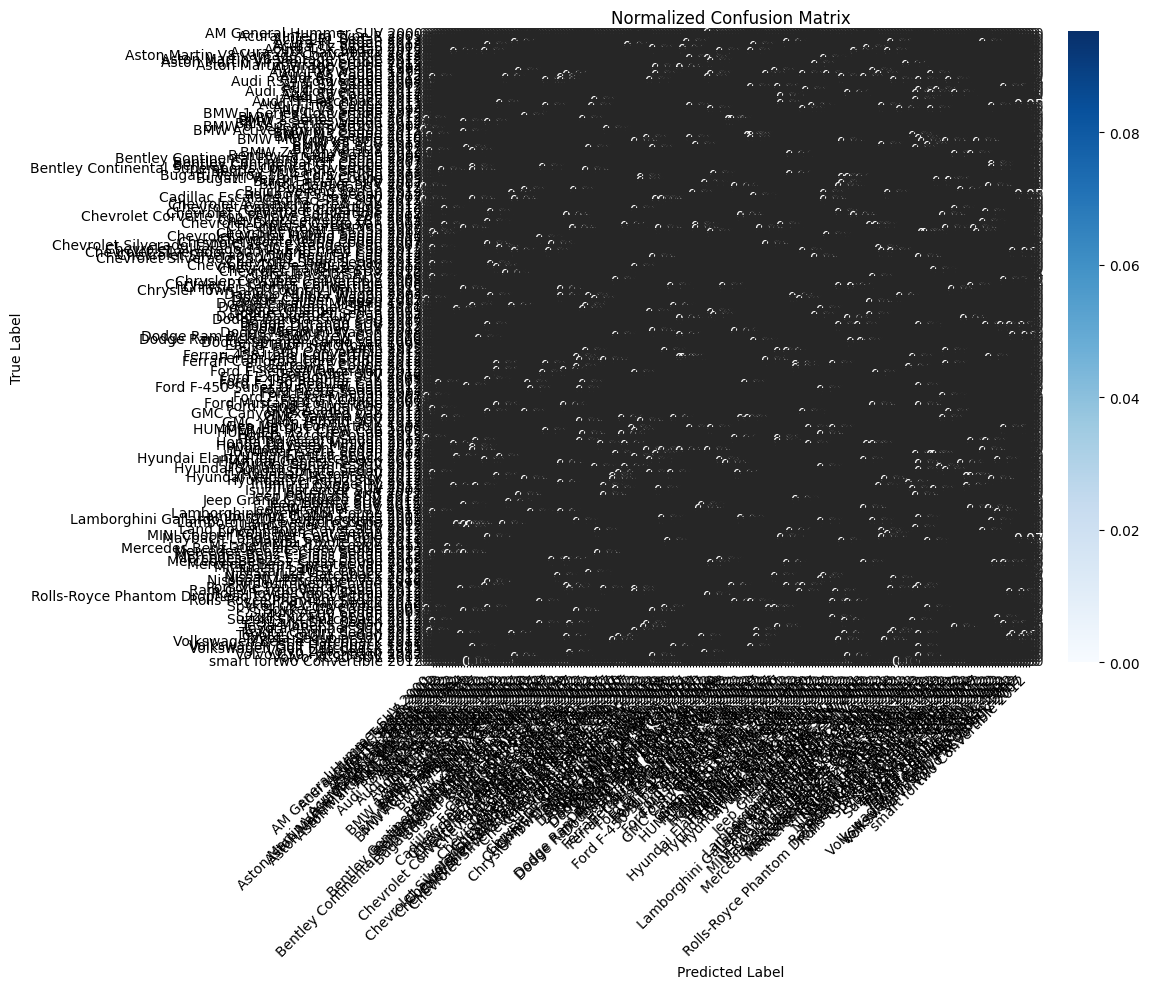

In [24]:
# Compute confusion matrix and normalize it
conf_matrix = confusion_matrix(true_classes, predicted_classes)
conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

# Plotting Confusion Matrix
plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix_normalized, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels, cbar=True)

plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Normalized Confusion Matrix')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

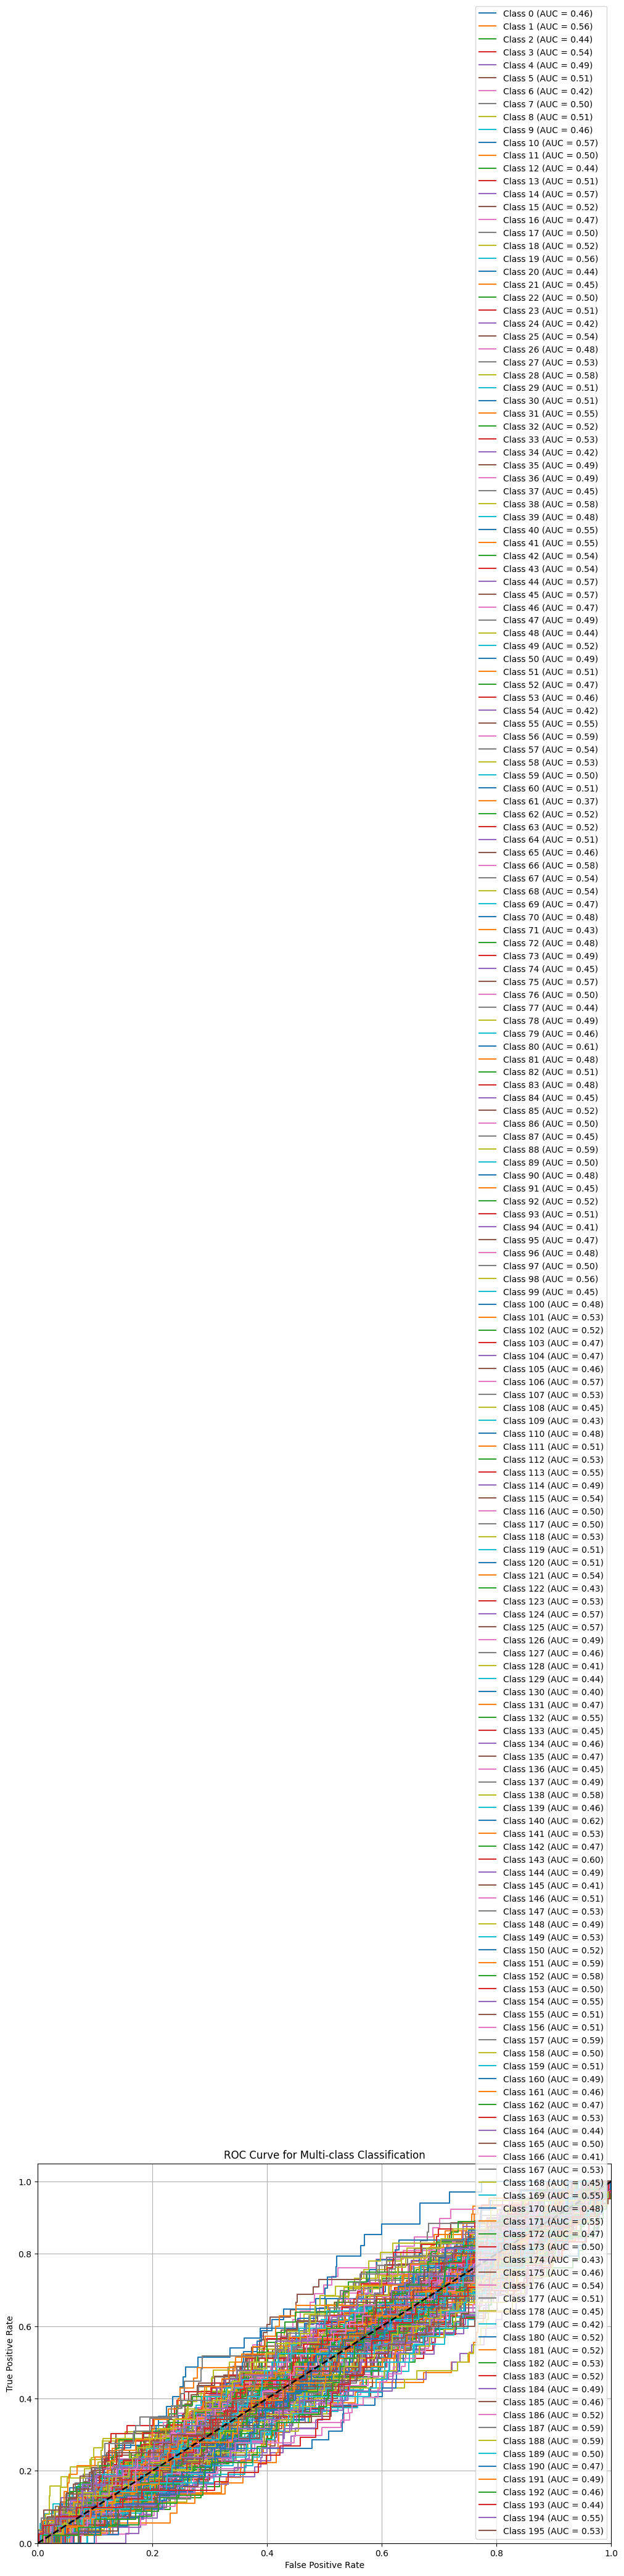

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Get true labels from the validation data generator
true_classes = val_data.classes  # This gives the true labels

# Binarize the output labels for multi-class ROC
n_classes = len(val_data.class_indices)  # Number of classes
true_classes_binarized = label_binarize(true_classes, classes=range(n_classes))

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(true_classes_binarized[:, i], predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plotting the ROC curves
plt.figure(figsize=(12, 8))

for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

# Plotting the diagonal line
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multi-class Classification')
plt.legend(loc='lower right')
plt.grid()
plt.show()

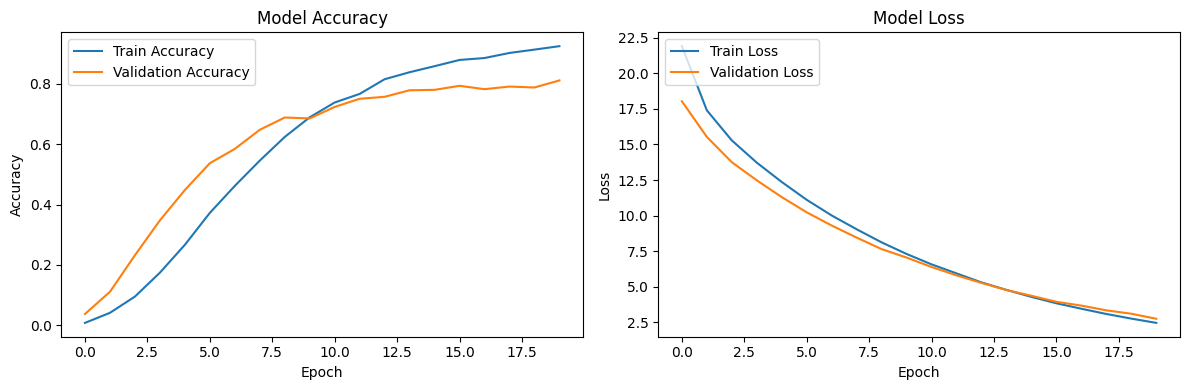

In [26]:
# Plot training & validation accuracy and loss
plt.figure(figsize=(12, 4))

# Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

In [27]:
from tensorflow.keras.models import load_model

# Load the saved model
model = load_model('best_weights.keras')

In [28]:
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt

def prediction(image_path, model, class_indices, target_size=(299, 299)):

    # Preprocess the image
    def preprocess_image(image_path, target_size=(299, 299)):
        img = load_img(image_path, target_size=target_size)
        img_array = img_to_array(img)
        img_array = img_array / 255.0
        return np.expand_dims(img_array, axis=0)

    # Preprocess the input image
    preprocessed_image = preprocess_image(image_path, target_size)

    # Make prediction
    predictions = model.predict(preprocessed_image)
    predicted_label = np.argmax(predictions, axis=1)[0]

    # Map the predicted label to the class name
    class_labels = {v: k for k, v in class_indices.items()}
    predicted_class = class_labels[predicted_label]

    # Display the image with the prediction
    img = load_img(image_path, target_size=target_size)
    plt.imshow(img)
    plt.title(f"Predicted: {predicted_class}")
    plt.axis('off')
    plt.show()

    return predicted_class

1/1 ━━━━━━━━━━━━━━━━━━━━ 17s 17s/step


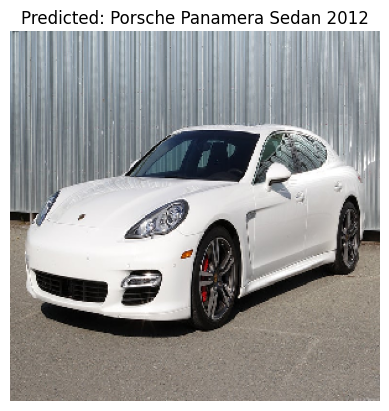

The predicted class is: Porsche Panamera Sedan 2012


In [30]:
# Call the function
image_path = "35043594_OVR.jpg"  # Replace with your image path
predicted_class = prediction(image_path, model, train_data.class_indices)

print(f"The predicted class is: {predicted_class}")